# Bayesian Online Changepoint Detection

This notebook shows `BOCD` in action using the pickled model configs saved in `model_config`. 

We first use the `predict_many` method of our `Model` class, and then show how our online model achieves approximately equal outputs using the `predict` method. The outputs are not identical because `predict_many` is not updating the Welford configuration (i.e. the underlying mean and variance of the distribution) with every update, whereas `predict` is. This is just a test to show the performance of the model AFTER the testing period:

- Training: UST Wormhole pool from Jan to Jun 22
- Testing: All other pools from Jan 22 to May 23
- This notebook: Modeled pools from May 23 to Jun 23

In [1]:
from datetime import datetime, timedelta
import os
import json
import re
import pickle
import pandas as pd

from curvemetrics.src.classes.logger import Logger
from curvemetrics.src.classes.datahandler import DataHandler
from curvemetrics.src.classes.modelsetup import ModelSetup
from curvemetrics.src.plotting.plot import bocd_plot_comp, run_length_plot

PERIOD = 60*60 # 1 hour
BUFFER = 60*10 # 10 minutes
WINDOW = timedelta(days=1) # Markout window for Sharks (5 minutes for markout metric)
SLIDING_WINDOW = timedelta(seconds=PERIOD)
RETRIES = 3

POOL_METRICS = ["shannonsEntropy", 
                "netSwapFlow", 
                "300.Markout"
]
MODELED_POOLS = [
    "0xdc24316b9ae028f1497c275eb9192a3ea0f67022", # ETH/stETH
    "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7", # 3pool
    "0xdcef968d416a41cdac0ed8702fac8128a64241a2", # FRAX/USDC
    "0xa1f8a6807c402e4a15ef4eba36528a3fed24e577", # ETH/frxETH
    "0x828b154032950c8ff7cf8085d841723db2696056", # stETH Concentrated
]

def load_config():
    # Load the configuration
    s = os.path.join(os.path.abspath('config.json'))
    s = re.sub(r'(/root/curve-lp-metrics/).*', r'\1', s) + 'config.json'
    with open(s, "r") as config_file:
        config = json.load(config_file)
    return config

config = load_config()

def get_model_start(dt):
    return int(datetime.timestamp(datetime(dt.year, dt.month, dt.day, dt.hour) - timedelta(hours=2)))

def get_model_end(dt):
    return int(datetime.timestamp(datetime(dt.year, dt.month, dt.day, dt.hour)))

def main(models, now):
    """
    This script does the following, in order, every hour, forever:

    1. Frontfill raw data
    2. Computes and frontfills metrics
    3. Computes and frontfills new takers stats and sharkflow metric
    4. Runs one inference step on all models and frontfills the results

    Fault tolerance:

    If steps (1-3) fail, the script will retry them 3 times, with a 10 second delay between each retry.
    If they still fail, the script will:
    1. Log the error
    2. Send an email to the Xenophon Labs team
    3. Tweet about the error
    4. Exit

    If step (4) fails for any model, the script will retry that model 3 times.
    If it still fails, the script will:
    1. Log the error
    2. Send an email to the Xenophon Labs team
    3. Tweet about the error
    4. Retire the failing model
    5. Continue to the next model
    """
    logger = Logger('./logs/frontfill/inference.log').logger
    try:
        dt = datetime.fromtimestamp(now)
        model_start = get_model_start(dt)
        model_end = get_model_end(dt) - 0.00001

        datahandler = DataHandler()
        tuner = ModelSetup(datahandler, logger=logger)

        ### Model Inference
        for pool in MODELED_POOLS:

            name = datahandler.pool_metadata[pool]['name']
            
            baseline = models[pool]['baseline']

            lp_share_price = datahandler.get_pool_metric_last(pool, 'lpSharePrice')[0]
            if pool in tuner.ETH_POOLS:
                eth_price = datahandler.get_ohlcv_data_last(datahandler.token_ids['ETH'])['close'][0]
                lp_share_price /= eth_price
            elif pool in tuner.CRV_POOLS:
                crv_price = datahandler.get_ohlcv_data_last(datahandler.token_ids['CRV'])['close'][0]
                lp_share_price /= crv_price
            virtual_price = datahandler.get_pool_snapshots_last(pool)['virtualPrice'][0] / 10**18

            is_true_cp = baseline.update(virtual_price, lp_share_price, model_start)
            if is_true_cp:
                true_cp = baseline.last_cp
                # datahandler.insert_changepoints([baseline.last_ts], pool, 'baseline', baseline)
                print(f'Changepoint detected for {name} with baseline model at {datetime.fromtimestamp(true_cp)}.')

            # with open(f'./model_configs/baseline/{pool}.pkl', 'wb') as f:
            #     pickle.dump(baseline, f)

            for metric in POOL_METRICS:
                print(f'Running inference for {pool} with {metric} at {datetime.fromtimestamp(now)}.')
                model = models[pool][metric]
                X = datahandler.get_pool_X(metric, pool, model_start, model_end, '1h')
                x, ts = X[-1], datetime.timestamp(X.index[-1])
                # Ensure we are getting complete, non-overlapping data
                assert ts == model.last_ts + PERIOD 
                is_cp = model.predict(x, ts)
                if is_cp:
                    cp = now
                    # datahandler.insert_changepoints([cp], pool, 'bocd', metric)
                    print(f'Changepoint detected for {name} with {metric} at {cp}.')

                # with open(f'./model_configs/{metric}/{pool}.pkl', 'wb') as f:
                #     pickle.dump(model, f)

    except Exception as e:
        print(f'Failed to run inference: {e}')
        raise e

    finally:
        datahandler.close()

    return models

In [2]:
start = datetime.timestamp(datetime(2023, 5, 1, 3, 1))
end = datetime.timestamp(datetime.now())

datahandler = DataHandler()

POOL_METRICS = ["shannonsEntropy", 
                "netSwapFlow", 
                "300.Markout"
]
MODELED_POOLS = [
    "0xdc24316b9ae028f1497c275eb9192a3ea0f67022", # ETH/stETH
    "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7", # 3pool
    "0xdcef968d416a41cdac0ed8702fac8128a64241a2", # FRAX/USDC
    "0xa1f8a6807c402e4a15ef4eba36528a3fed24e577", # ETH/frxETH
    "0x828b154032950c8ff7cf8085d841723db2696056", # stETH Concentrated
]

models = {}
for pool in MODELED_POOLS:
    with open(f'../model_configs/baseline/{pool}.pkl', 'rb') as f:
        baseline = pickle.load(f)
    models[pool] = {}
    models[pool]['baseline'] = baseline
    for metric in POOL_METRICS:
        with open(f'../model_configs/{metric}/{pool}.pkl', 'rb') as f:
            model = pickle.load(f)
        model.logger = Logger(f'../logs/frontfill/inference_{pool}_{metric}.log').logger
        models[pool][metric] = model

# res = {}
# for pool in MODELED_POOLS:
#     res[pool] = {}
#     for metric in POOL_METRICS:
#         X = datahandler.get_pool_X(metric, pool, start, end, '1h')
#         model = models[pool][metric]
#         X = (X - model.welly.mean)/model.welly.std
#         cps, rt_mle = model.predict_many(X)
#         res[pool][metric] = (cps, rt_mle)

In [6]:
datahandler.pool_metadata['0xdcef968d416a41cdac0ed8702fac8128a64241a2']['name']

'Curve.fi FRAX/USDC'

In [20]:
for pool in MODELED_POOLS:
    for metric in POOL_METRICS:
        cps, rt_mle = res[pool][metric]
        if len(cps):
            print(pool, metric)

0xdc24316b9ae028f1497c275eb9192a3ea0f67022 300.Markout
0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7 shannonsEntropy
0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7 300.Markout
0xdcef968d416a41cdac0ed8702fac8128a64241a2 300.Markout
0xa1f8a6807c402e4a15ef4eba36528a3fed24e577 shannonsEntropy
0xa1f8a6807c402e4a15ef4eba36528a3fed24e577 netSwapFlow
0xa1f8a6807c402e4a15ef4eba36528a3fed24e577 300.Markout
0x828b154032950c8ff7cf8085d841723db2696056 shannonsEntropy
0x828b154032950c8ff7cf8085d841723db2696056 300.Markout


In [27]:
def check(pool, metric, start, end):
    datahandler = DataHandler()
    tuner = ModelSetup(datahandler)

    lp_share_price = datahandler.get_pool_metric(pool, 'lpSharePrice', start, end)
    if pool in tuner.ETH_POOLS:
        eth_price = datahandler.get_ohlcv_data(datahandler.token_ids['ETH'], start, end)['close']
        lp_share_price /= eth_price
    elif pool in tuner.CRV_POOLS:
        crv_price = datahandler.get_ohlcv_data(datahandler.token_ids['CRV'], start, end)['close']
        lp_share_price /= crv_price
    virtual_price = datahandler.get_pool_snapshots(pool, start, end)['virtualPrice'] / 10**18

    X = datahandler.get_pool_X(metric, pool, start, end, '1h')

    return lp_share_price, virtual_price, X

pool = '0xa1f8a6807c402e4a15ef4eba36528a3fed24e577'
name = datahandler.pool_metadata[pool]['name']
metric = 'shannonsEntropy'

cps, rt_mle = res[pool][metric]

lp_share_price, virtual_price, X = check(pool, metric, start, end)

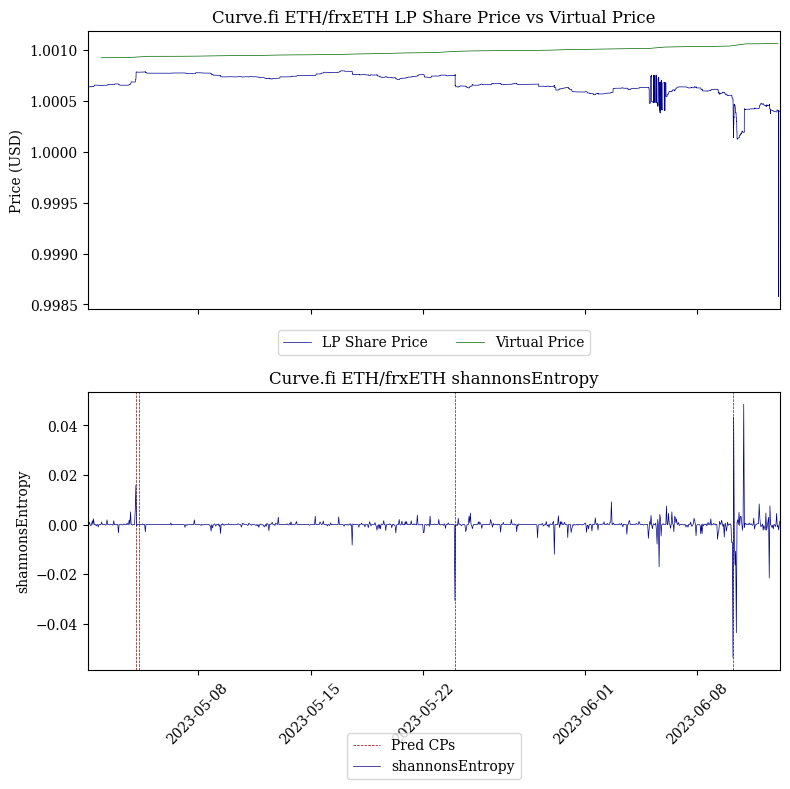

In [28]:
bocd_plot_comp(X, lp_share_price, virtual_price, [], cps, save=False, show=True, metric=metric, pool=name)

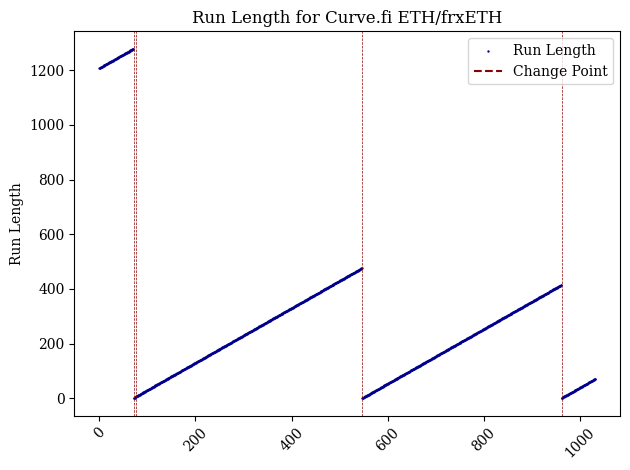

In [29]:
run_length_plot(pd.Series(rt_mle), name, show=True, save=False)

In [39]:
margin = config['model_configs']['base']['margin']
alpha = config['model_configs']['base']['alpha']
models = {}
MODELED_POOLS = [pool]
POOL_METRICS = [metric]
for pool in MODELED_POOLS:
    with open(f'./model_configs/baseline/{pool}.pkl', 'rb') as f:
        baseline = pickle.load(f)
    models[pool] = {}
    models[pool]['baseline'] = baseline
    for metric in POOL_METRICS:
        with open(f'./model_configs/{metric}/{pool}.pkl', 'rb') as f:
            model = pickle.load(f)
        model.logger = Logger(f'./logs/frontfill/inference_{pool}_{metric}.log').logger
        model.last_ts += PERIOD
        models[pool][metric] = model

now = start
while now <= end:
    models = main(models, now)
    now += PERIOD

Running inference for 0xa1f8a6807c402e4a15ef4eba36528a3fed24e577 with shannonsEntropy at 2023-05-01 03:01:00.
Running inference for 0xa1f8a6807c402e4a15ef4eba36528a3fed24e577 with shannonsEntropy at 2023-05-01 04:01:00.
Running inference for 0xa1f8a6807c402e4a15ef4eba36528a3fed24e577 with shannonsEntropy at 2023-05-01 05:01:00.
Running inference for 0xa1f8a6807c402e4a15ef4eba36528a3fed24e577 with shannonsEntropy at 2023-05-01 06:01:00.
Running inference for 0xa1f8a6807c402e4a15ef4eba36528a3fed24e577 with shannonsEntropy at 2023-05-01 07:01:00.
Running inference for 0xa1f8a6807c402e4a15ef4eba36528a3fed24e577 with shannonsEntropy at 2023-05-01 08:01:00.
Running inference for 0xa1f8a6807c402e4a15ef4eba36528a3fed24e577 with shannonsEntropy at 2023-05-01 09:01:00.
Running inference for 0xa1f8a6807c402e4a15ef4eba36528a3fed24e577 with shannonsEntropy at 2023-05-01 10:01:00.
Running inference for 0xa1f8a6807c402e4a15ef4eba36528a3fed24e577 with shannonsEntropy at 2023-05-01 11:01:00.
Running in

## Detected Changepoints

In [41]:
# From online model `predict`
[datetime.fromtimestamp(x) for x in [1683176460, 1683190860, 1684886460, 1686376860, 1686592860]]

[datetime.datetime(2023, 5, 4, 5, 1),
 datetime.datetime(2023, 5, 4, 9, 1),
 datetime.datetime(2023, 5, 24, 0, 1),
 datetime.datetime(2023, 6, 10, 6, 1),
 datetime.datetime(2023, 6, 12, 18, 1)]

In [42]:
# From `predict_many`
cps

DatetimeIndex(['2023-05-04 04:00:00', '2023-05-04 08:00:00',
               '2023-05-23 23:00:00', '2023-06-10 05:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)